In [1]:
import pickle
from pathlib import Path
import os
os.chdir(r"C:\Users\everett\Documents\GitHub\neuralhydrology\neuralhydrology")
from neuralhydrology.datasetzoo import get_dataset, hysets
import pandas as pd
import tqdm
import xarray as xr 
from tqdm import tqdm
import numpy as np
import warnings


data_dir = Path(r"C:\Users\everett\Documents\GitHub\neuralhydrology\neuralhydrology\data\hysets")
# Load the forcings input for the corresponding date range
date_range = pd.date_range('01-01-1950', '01-01-2000', freq='1D')
forcings = hysets.load_hysets_timeseries(data_dir, '10').loc[date_range]
print(forcings.columns)

Index(['discharge(mm/d)', 'precip(mm/d)', 'tmax(C)', 'tmin(C)', 'swe(mm/d)'], dtype='object')


In [2]:
os.chdir(r"C:\Users\everett\Documents\GitHub\neuralhydrology\neuralhydrology")

df = hysets.load_hysets_attributes(data_dir)
df = df[df.Source == "HYDAT"]
df.head


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


In [2]:

import pandas as pd
import pickle
from pathlib import Path
import os
os.chdir(r"C:\Users\everett\Documents\GitHub\neuralhydrology\neuralhydrology")
import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.datasetzoo import get_dataset, hysets


# by default we assume that you have at least one CUDA-capable NVIDIA GPU

os.chdir(r"C:\Users\everett\Documents\GitHub\neuralhydrology\neuralhydrology\examples\10-Hysets")

if torch.cuda.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)


2023-01-20 10:52:13,286: Logging to C:\Users\everett\Documents\GitHub\neuralhydrology\neuralhydrology\examples\10-Hysets\runs\test_run_2001_105213\output.log initialized.
2023-01-20 10:52:13,287: ### Folder structure created at C:\Users\everett\Documents\GitHub\neuralhydrology\neuralhydrology\examples\10-Hysets\runs\test_run_2001_105213
2023-01-20 10:52:13,287: ### Run configurations for test_run
2023-01-20 10:52:13,288: experiment_name: test_run
2023-01-20 10:52:13,288: train_basin_file: 1_basin.txt
2023-01-20 10:52:13,289: validation_basin_file: 1_basin.txt
2023-01-20 10:52:13,289: test_basin_file: 1_basin.txt
2023-01-20 10:52:13,289: train_start_date: 1999-10-01 00:00:00
2023-01-20 10:52:13,290: train_end_date: 2008-09-30 00:00:00
2023-01-20 10:52:13,290: validation_start_date: 1980-10-01 00:00:00
2023-01-20 10:52:13,291: validation_end_date: 1989-09-30 00:00:00
2023-01-20 10:52:13,291: test_start_date: 1989-10-01 00:00:00
2023-01-20 10:52:13,292: test_end_date: 1999-09-30 00:00:00


KeyError: "The following features are not available in the data: ['flow(m3/s)']. These are the available features: ['Qobs(mm/d)', 'precip(mm/d)', 'tmax(C)', 'tmin(C)', 'swe(mm/d)']"

In [28]:

def hystats(tt:pd.DataFrame) -> dict():
    x = dict()

    tt_interp = tt.copy()

    # calculate mean annual statistics (except for precip. params, which are summed across the year)
    sum_params = ["precip","rain","rainfall","snow","snowfall","swe"]
    tt_annual = pd.merge(tt.loc[:,[any(w.upper() in x for w in sum_params) for x in tt.columns]].resample('Y').sum(),
                    tt.loc[:,[all(w.upper() not in x for w in sum_params) for x in tt.columns]].resample('Y').mean(),left_index=True,right_index=True)

    # some parameters require long stretches of continuous data - here we create a continuous copy of the timeseries' using linear interpolation
    for col in tt.columns:    
        tt_col = tt[col].copy()
        tt_adjusted = tt_col[tt_col.first_valid_index():tt_col.last_valid_index()].copy()
        tt_adjusted.interpolate(method='linear', inplace=True)
        tt_col[tt_col.first_valid_index():tt_col.last_valid_index()] = tt_adjusted
        
        tt_interp[col] = tt_col
        del tt_col, tt_adjusted
    
    if tt.shape[0] < 365:
        warnings.warn('insufficient data to calculate hymet stats, returning empty dict.')
        return x
    
    x['precip_mean'] = tt['precip'].mean()
    
    x['precip_high'] = x['precip_mean'] * 5
    x['precip_low'] = 1
    
    x['precip_mean_monthly'] = tt_interp['precip'].resample('M').sum().mean()
    x['precip_mean_annual'] = tt_interp['precip'].resample('Y').sum().mean()

    x['high_precip_freq'] = np.sum(tt_interp['precip'] > x['precip_high'])
    x['high_precip_dur'] = sequence_duration(tt_interp['precip'] > x['precip_high'])
    
    x['low_precip_freq'] = np.sum(tt_interp['precip'] < x['precip_low'])
    x['low_precip_dur'] = sequence_duration(tt_interp['precip'] < x['precip_low'])
    
    bf = baseflow_lyne_hollick(tt_interp.loc[:,'flow'])
    x['baseflow_index'] = np.mean(bf) / tt_interp.mean().values[0]
    
    x['flow_mean'] = tt_interp['flow'].mean()
    x['flow_high'] = x['flow_mean'] * 9
    x['flow_low'] = x['flow_mean'] * 0.2
    
    
    x['high_flow_freq'] = np.sum(tt_interp['flow'] > x['flow_high'])
    x['high_flow_dur'] = sequence_duration(tt_interp['flow'] > x['flow_high'])
    
    
    x['low_flow_dur'] = sequence_duration(tt_interp['flow'] < x['flow_low'])
    
    x['zero_flow_freq'] = np.sum(tt_interp['flow'] == 0)
    
    x['q95'] = tt_interp['flow'].quantile(0.95)
    x['q5'] = tt_interp['flow'].quantile(0.05)
    
    if area_km2 is not np.nan:   
        area_m = area_km2 * 1000000
        # select flow and precip
        qp = tt.loc[:,['flow','precip']].copy()
        # remove timesteps with any nans
        qp = qp.loc[np.all(~np.isnan(qp),axis=1),:]
        qp['flow'] = qp['flow'] * 3600 * 24 * 1000 / area_m
        x['runoff_ratio'] = qp['flow'].sum() / qp['precip'].sum()
        del qp

    result = adfuller(tt['flow'].dropna())
    x['flow_adf'] = result[0]
    x['flow_adf_p'] = result[1]
    # x['flow_adf'] = result[0]
    # x['flow_adf'] = result[0]
    x['flow_adf_cv1'] = result[4]['1%']
    x['flow_adf_cv5'] = result[4]['5%']
    x['flow_adf_cv10'] = result[4]['10%']
    
    if tt['flow'].dropna().shape[0] >= 730:
        result = seasonal_decompose(tt['flow'].dropna(), model='additive', period=365)
        x['flow_seasonality'] = np.array([0,1 - result.resid.var()/(result.seasonal + result.resid).var()]).max()
    else:
        x['flow_seasonality'] = np.nan
        
    if tt['tmean'].dropna().shape[0] >= 730:
        result = seasonal_decompose(tt['tmean'].dropna(), model='additive', period=365)
        x['temp_seasonality'] = np.array([0,1 - result.resid.var()/(result.seasonal + result.resid).var()]).max()
    else:
        x['temp_seasonality'] = np.nan
    
    

    x['temp_mean'] = tt['tmean'].mean()
    x['temp_max'] = tt.loc[:,'tmax'].resample('Y').max().mean() # annual minimum, then average annual min - doing straight min gives all time low, which doesn't vary much cross canada
    x['temp_min'] = tt.loc[:,'tmin'].resample('Y').min().mean()
    
    
    
    return x


In [19]:
results['31']['1D']['xr']

{'1D': {'xr': <xarray.Dataset>
  Dimensions:         (date: 3652, time_step: 1)
  Coordinates:
    * date            (date) datetime64[ns] 1989-10-01 1989-10-02 ... 1999-09-30
    * time_step       (time_step) int64 0
  Data variables:
      flow(m3/s)_obs  (date, time_step) float32 2.0 1.8 4.98 ... 13.4 10.8 8.91
      flow(m3/s)_sim  (date, time_step) float32 9.922 1.143 6.652 ... 16.77 11.62,
  'NSE': -12.802987098693848}}

2023-01-19 06:33:59,135: Using the model weights from runs\test_run_1901_061207\model_epoch003.pt
# Evaluation: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]
2023-01-19 06:34:04,874: Stored results at runs\test_run_1901_061207\test\model_epoch003\test_results.p


Text(0.5, 1.0, 'Test period - NSE -12.803')

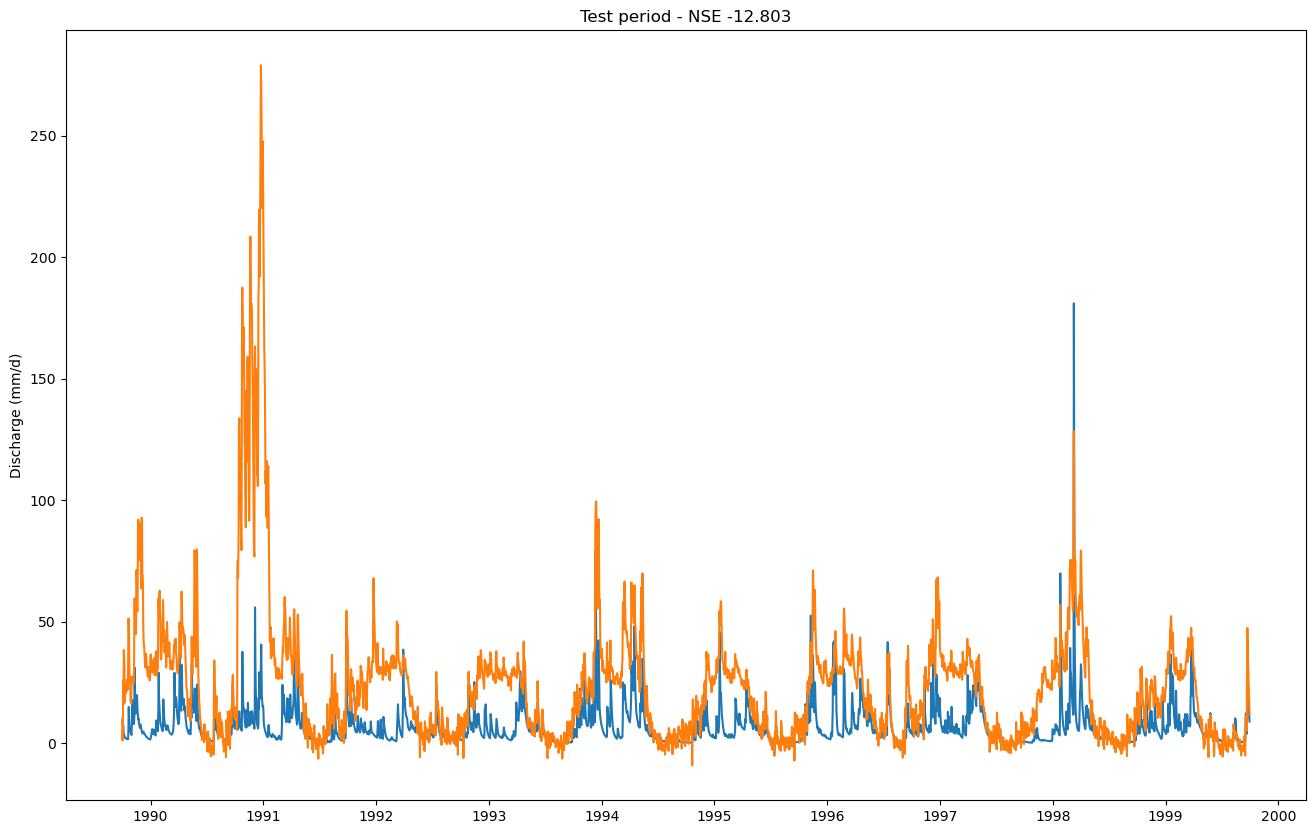

In [17]:
run_dir = Path("runs/test_run_1901_061207")
eval_run(run_dir=run_dir, period="test")
with open(run_dir / "test" / "model_epoch003" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)



    
results.keys()



# extract observations and simulations
qobs = results['31']['1D']['xr']['flow(m3/s)_obs']
qsim = results['31']['1D']['xr']['flow(m3/s)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['31']['1D']['NSE']:.3f}")